## Visualizing results 7th Edition-  SpaCy Geottaging + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

We have used the **Seventh Edition of the Encyclopaedia Britannica**. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_7_edition.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_7_edition' -n 16`


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(df_group_places):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['place_label']))
    plt.bar(index, df_group_places['count'], color='green')
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['place_label'], rotation=40, fontsize=8)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from the directory "144133901",  which corresponds to the book "Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata


As a result we get a file per gazetter|book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver 
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 


Example:
- edition: First edition, 1771, Volume 1, A-B
  - georesolution_page:
    - SCOTLAND-1:
     - '33.64836'
     - '-98.46944999999999'
  - lang_model: en_core_web_lg
  - page_filename: alto/188082826.34.xml
  - text_unit id: Page9
  - year: 1771



In [7]:
results=read_query_results('georesolution_en_core_web_lg_EB_7_edition')

In [8]:
df_total= geresolution_dataframe(results)

In [9]:
df_total[["Place"]].count()

Place    257519
dtype: int64

In [10]:
df_total["Place"]= df_total["Place"].str.capitalize()

In [11]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
+,1,1,1
"+2,z",1,1,1
"/3,7",1,1,1
"0,0000625826.",1,1,1
1 america,1,1,1
1 berlin,1,1,1
1 england,2,2,2
1 island,1,1,1
1 sea,1,1,1


In [12]:
#df_total.groupby("Page").count()

In [13]:
#df_total.groupby(["Latitude", "Longitude"]).count()

In [14]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

df_max_geolocations = df_filter.drop(0)

df_max_geolocations.head(15)


,Latitude,Longitude,count
1259,-3.4869444,-43.2258333,6071
20520,47.43047,19.07098,4011
20596,47.5183,19.10789,3317
7295,34.6120507,-82.765139,2839
26499,54,-4,2231
16748,43.2256251,-75.48878740000001,2226
15682,42.4812059,-71.2089445,1847
8325,36.2436749,-85.243301,1817
9803,38.3242916,-76.5168989,1760
21656,49.012779,2.55,1745


In [19]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=['Earth', 'The moon', 'Meridian', 'Jupiter', 'Venus', 'Kingdom', 'Vi', 'Xxi', 'Xiv', 'Ii']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)
    

3 2839 France
4 2231 England
5 2226 Rome
7 1817 France
9 1745 Paris
10 1561 France
11 1546 England
12 1395 Holland
13 1306 England
14 1169 Europe
15 1082 Scotland
16 1073 Hindustan
17 1072 England
18 1059 Russia
19 1044 Edinburgh
20 1016 Italy
21 1002 London
22 991 Asia
23 984 England
24 966 Europe
25 960 Great britain
26 906 Rome
27 874 Paris
28 803 London
29 765 Greece


In [20]:
#Visualizing the 15 places in a Bar plot
df_places = {'place_label':place_label,'place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['place_label'])['place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


df_group_places

,place_label,count
2,England,7139
4,France,6217
12,Rome,3132
11,Paris,2619
3,Europe,2135
10,London,1805
8,Holland,1395
14,Scotland,1082
7,Hindustan,1073
13,Russia,1059


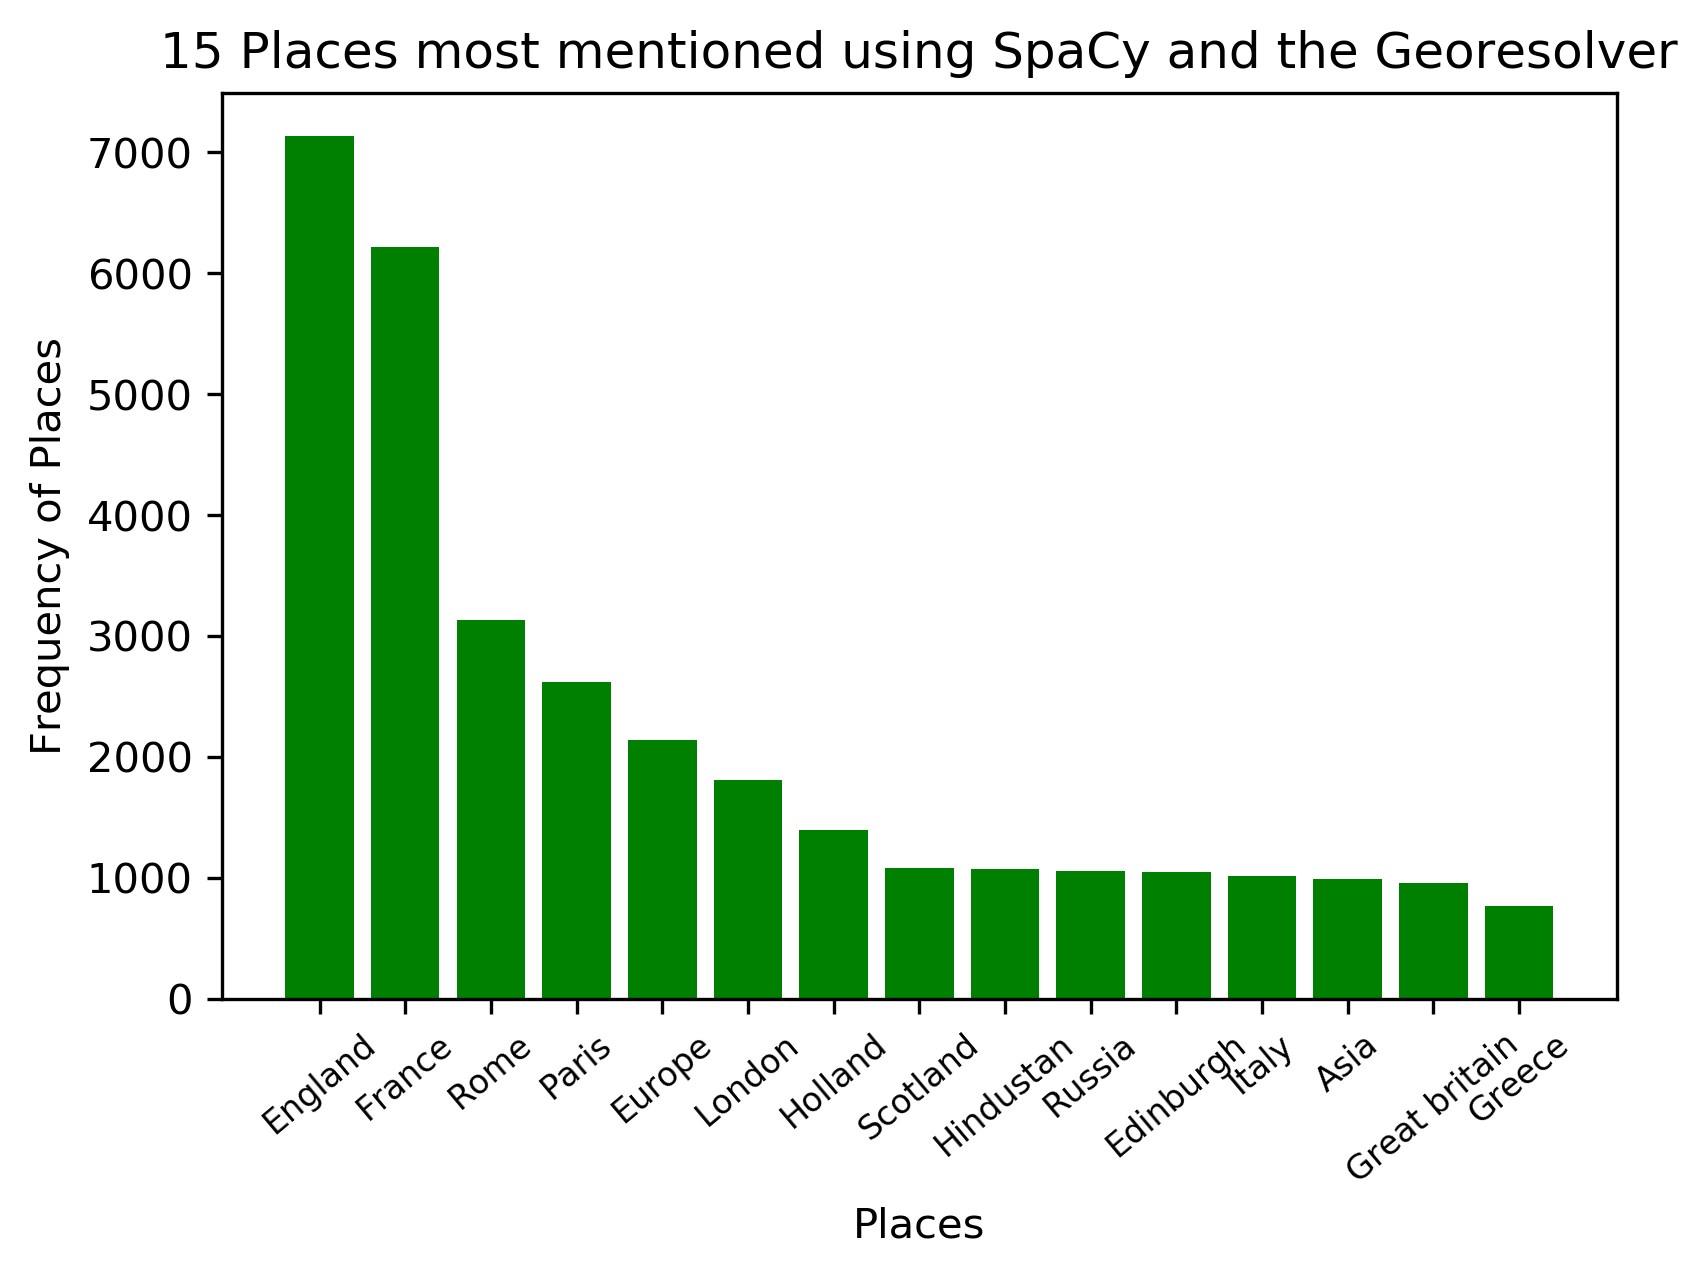

In [21]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places)